# Adoption Analysis with Enhanced EDA

In [1]:
import os
import pandas as pd
import numpy as np
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import date

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Adoption Analysis with Enhanced EDA

This notebook performs a comprehensive analysis of product adoption patterns, including:

1. Data loading and preparation from Supabase
2. Exploratory Data Analysis (EDA) with visualizations
3. Adoption rate analysis across different segments
4. Behavioral comparisons between adopters and non-adopters
5. Correlation analysis between adoption and behavioral metrics
6. Saving results to Supabase

Let's start by defining our helper functions.

In [2]:
# DuckDB connection
DB_PATH = "C:/Users/Reverside/Documents/Git/UbuntuBankSA/data/ubuntubank.db"

def get_duckdb_connection():
    """Get connection to DuckDB database"""
    return duckdb.connect(DB_PATH)

conn = get_duckdb_connection()
print("Connected to DuckDB")

Connected to DuckDB


## 3. Data Loading

Now let's connect to Supabase and load the necessary tables for our analysis.

In [4]:
def fetch_table(conn, table_name):
    """Fetch table from DuckDB if it exists"""
    try:
        return conn.execute(f"SELECT * FROM {table_name}").fetchdf()
    except Exception:
        print(f"Table {table_name} does not exist in DuckDB.")
        return pd.DataFrame()

dim_client = fetch_table(conn, "dim_client")
fact_client_monthly = fetch_table(conn, "fact_client_monthly")
fact_txn_daily = fetch_table(conn, "fact_transactions_daily")

print(f"dim_client shape: {dim_client.shape}")
print(f"fact_client_monthly shape: {fact_client_monthly.shape}")
print(f"fact_txn_daily shape: {fact_txn_daily.shape}")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

dim_client shape: (30000, 16)
fact_client_monthly shape: (492894, 19)
fact_txn_daily shape: (16858121, 8)


## 4. Data Cleaning and Preparation

Let's clean and prepare our data for analysis by handling missing values, duplicates, and data type conversions.

In [5]:
# ================== 3. Data Cleaning ==================
def check_missing(df, name):
    missing = df.isna().sum()
    missing = missing[missing > 0]
    print(f"{name}: Missing values\n{missing}") if not missing.empty else print(f"{name}: No missing values")

def check_duplicates(df, name, subset=None):
    before = df.shape[0]
    df = df.drop_duplicates(subset=subset, keep="first").reset_index(drop=True)
    dropped = before - df.shape[0]
    print(f"{name}: {dropped} duplicates removed" if dropped else f"{name}: No duplicates")
    return df

def ensure_numeric(df, col, name):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def detect_outliers(df, col, name):
    if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
        return
    q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    n = ((df[col] < lo) | (df[col] > hi)).sum()
    print(f"{name}.{col}: {n} outliers detected")

# Apply cleaning
print("\n=== Cleaning dim_client ===")
dim_client = check_duplicates(dim_client, "dim_client", subset=["client_sk"])
check_missing(dim_client, "dim_client")

print("\n=== Cleaning fact_client_monthly ===")
fact_client_monthly = check_duplicates(fact_client_monthly, "fact_client_monthly", ["client_sk", "month_sk"])
for col in ["avg_balance", "inflow_txn_cnt", "outflow_txn_cnt"]:
    fact_client_monthly = ensure_numeric(fact_client_monthly, col, "fact_client_monthly")
    detect_outliers(fact_client_monthly, col, "fact_client_monthly")

print("\n=== Cleaning fact_transactions_daily ===")
fact_txn_daily = check_duplicates(fact_txn_daily, "fact_transactions_daily", ["client_sk", "date_sk"])
for col in ["debit_amt", "credit_amt"]:
    fact_txn_daily = ensure_numeric(fact_txn_daily, col, "fact_transactions_daily")
    detect_outliers(fact_txn_daily, col, "fact_transactions_daily")

print("Cleaning complete")


=== Cleaning dim_client ===
dim_client: No duplicates
dim_client: No missing values

=== Cleaning fact_client_monthly ===
fact_client_monthly: 2452 duplicates removed
fact_client_monthly.avg_balance: 41772 outliers detected
fact_client_monthly.inflow_txn_cnt: 7398 outliers detected
fact_client_monthly.outflow_txn_cnt: 7365 outliers detected

=== Cleaning fact_transactions_daily ===
fact_transactions_daily: 83871 duplicates removed
fact_transactions_daily.debit_amt: 1085853 outliers detected
fact_transactions_daily.credit_amt: 1073972 outliers detected
Cleaning complete


## 5. Exploratory Data Analysis (EDA)

Let's explore the data through visualizations to understand patterns and relationships.

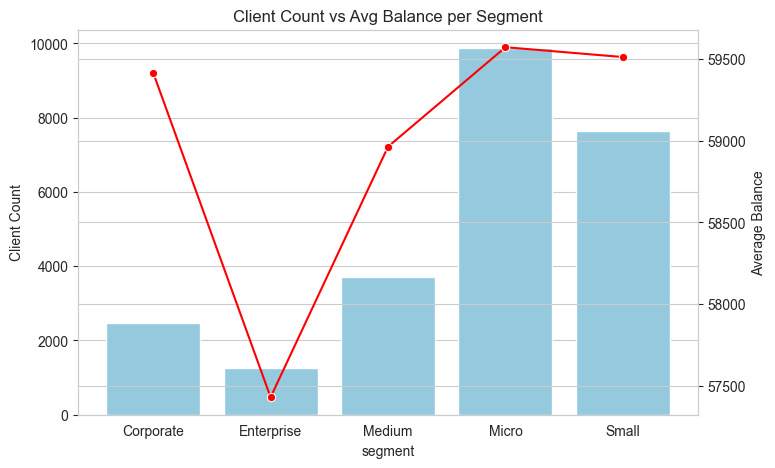

In [6]:
seg_summary = fact_client_monthly.merge(dim_client, on="client_sk") \
    .groupby("segment").agg(
        client_count=("client_sk","nunique"),
        avg_balance=("avg_balance","mean")
    ).reset_index()

fig, ax1 = plt.subplots(figsize=(8,5))

# Barplot for client counts
sns.barplot(data=seg_summary, x="segment", y="client_count", color="skyblue", ax=ax1)
ax1.set_ylabel("Client Count")
ax1.set_title("Client Count vs Avg Balance per Segment")

# Lineplot for avg balance on secondary axis
ax2 = ax1.twinx()
sns.lineplot(data=seg_summary, x="segment", y="avg_balance", marker="o", color="red", ax=ax2)
ax2.set_ylabel("Average Balance")

plt.show()

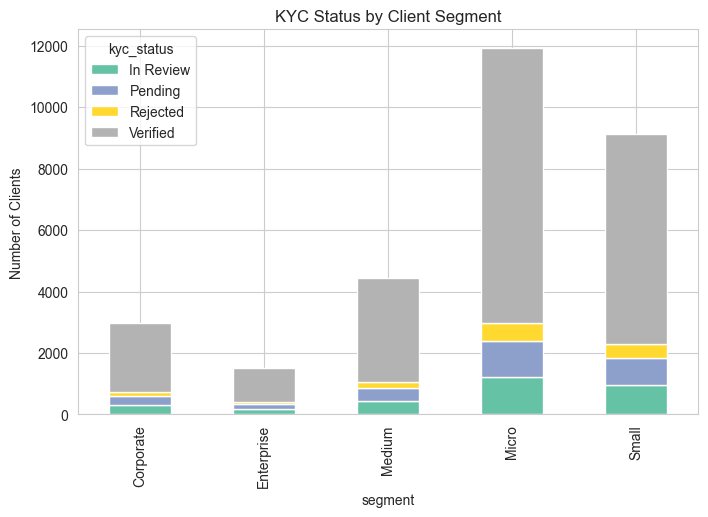

In [7]:
kyc_seg = dim_client.groupby(["segment","kyc_status"]).size().reset_index(name="count")
kyc_pivot = kyc_seg.pivot(index="segment", columns="kyc_status", values="count").fillna(0)

kyc_pivot.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Set2")
plt.title("KYC Status by Client Segment")
plt.ylabel("Number of Clients")
plt.show()



=== Segment vs Avg Balance ===
segment
Micro         59571.854469
Small         59511.753859
Corporate     59416.051908
Medium        58962.925775
Enterprise    57429.279725
Name: avg_balance, dtype: float64


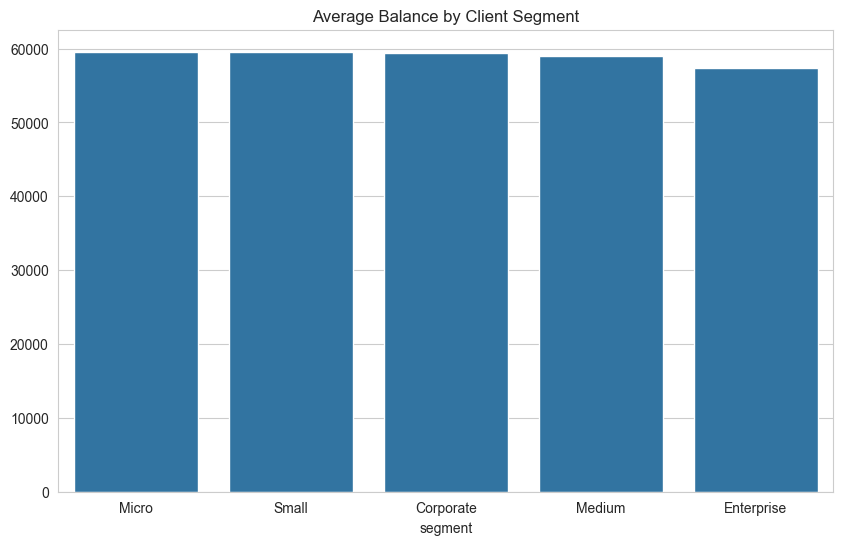


=== Segment vs KYC Status ===
kyc_status  In Review  Pending  Rejected  Verified
segment                                           
Corporate         313      273       152      2250
Enterprise        178      157        71      1103
Medium            442      426       190      3390
Micro            1209     1194       580      8944
Small             952      887       443      6846


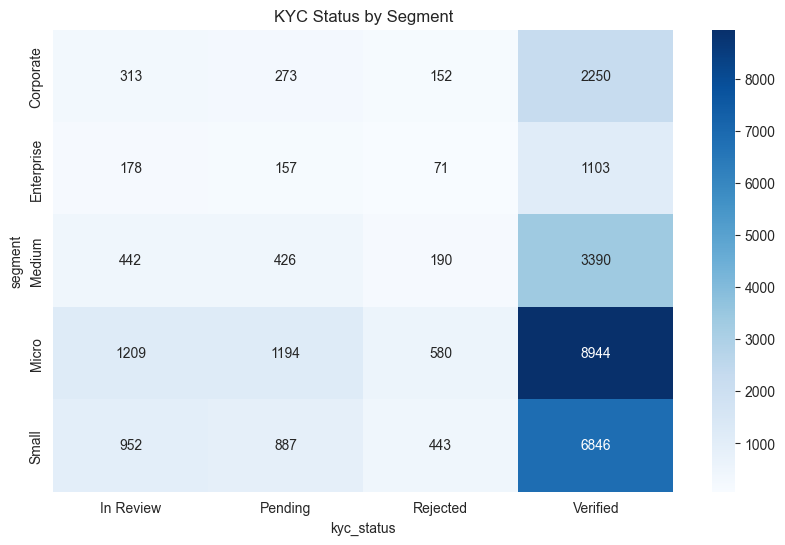

In [8]:
print("\n=== Segment vs Avg Balance ===")
seg_balance = fact_client_monthly.merge(dim_client, on="client_sk") \
    .groupby("segment")["avg_balance"].mean().sort_values(ascending=False)
print(seg_balance)

sns.barplot(x=seg_balance.index, y=seg_balance.values)
plt.title("Average Balance by Client Segment")
plt.show()

print("\n=== Segment vs KYC Status ===")
seg_kyc = dim_client.groupby(["segment", "kyc_status"]).size().unstack().fillna(0)
print(seg_kyc)
sns.heatmap(seg_kyc, annot=True, fmt="0.0f", cmap="Blues")
plt.title("KYC Status by Segment")
plt.show()

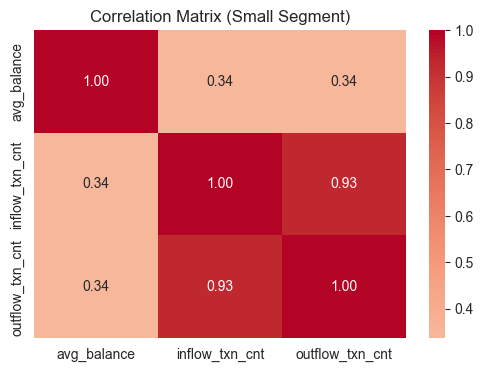

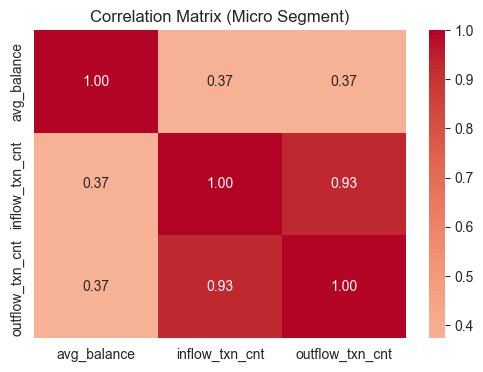

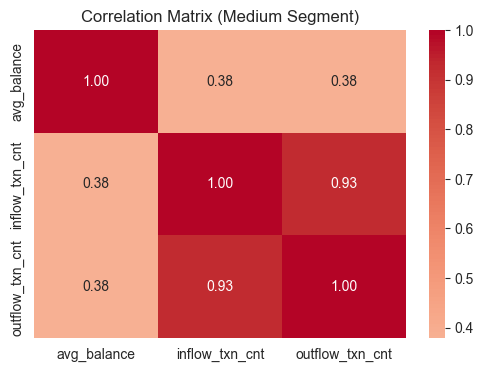

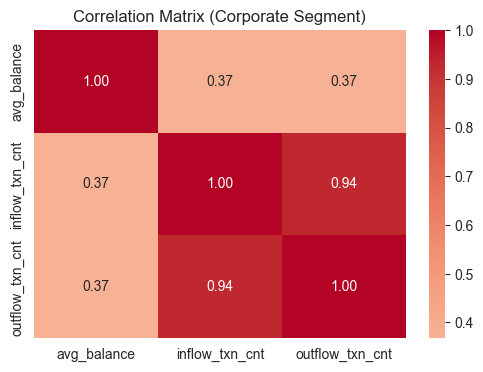

In [9]:
# Merge monthly facts with client segments
seg_corr = fact_client_monthly.merge(dim_client, on="client_sk")

# Loop over each segment and plot heatmap
for seg in seg_corr["segment"].unique():
    subset = seg_corr[seg_corr["segment"] == seg][["avg_balance","inflow_txn_cnt","outflow_txn_cnt"]]
    corr_matrix = subset.corr()

    plt.figure(figsize=(6,4))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
    plt.title(f"Correlation Matrix ({seg} Segment)")
    plt.show()

## 6. Analysis and Reporting

Now let's perform the quantitative analysis and prepare the results for reporting.

In [11]:
# ================== 5. Save Cleaned Tables Back to DuckDB ==================
def save_cleaned_table(conn, df, table_name):
    """Save cleaned table only if it does not already exist"""
    exists = conn.execute(f"""
        SELECT COUNT(*) 
        FROM information_schema.tables 
        WHERE table_name = '{table_name}'
    """).fetchone()[0]
    
    if exists == 0:
        conn.execute(f"CREATE TABLE {table_name} AS SELECT * FROM df")
        print(f"Saved cleaned table: {table_name}")
    else:
        print(f"Table {table_name} already exists. Skipping save.")

print("\n=== Saving cleaned tables ===")
save_cleaned_table(conn, dim_client, "dim_clients_cleaned")
save_cleaned_table(conn, fact_client_monthly, "fact_client_monthly_cleaned")
save_cleaned_table(conn, fact_txn_daily, "fact_transactions_daily_cleaned")

# ================== 6. Close ==================
conn.close()
print("EDA pipeline complete. DuckDB connection closed.")


=== Saving cleaned tables ===
Table dim_clients_cleaned already exists. Skipping save.
Table fact_client_monthly_cleaned already exists. Skipping save.
Table fact_transactions_daily_cleaned already exists. Skipping save.
EDA pipeline complete. DuckDB connection closed.


In [31]:
conn.close()